In [2]:
"""
imaging igabasnfr and 514.4409 at high resolution
data in: Z:\ilya\imaging\20201117_iGABASnFR_imaging_IK\synapse_imaging
excel spreadsheet in: Z:\ilya\imaging\20201117_iGABASnFR_imaging_IK\synapse_imaging\synapse-imaging-results.xlsx
imaging params: 
    Imaged on rig 2, 100% XCite light power
    160 FPS
    5 APs
    40X / 1.45 NA Oil objective
    16 DIV neurons in standard GENIE culture plate

"""

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import calc_dff_trace,debleach

 
# plt.close('all')

srate = 160
beginning_frames_to_ignore = 10 # remove fast transient


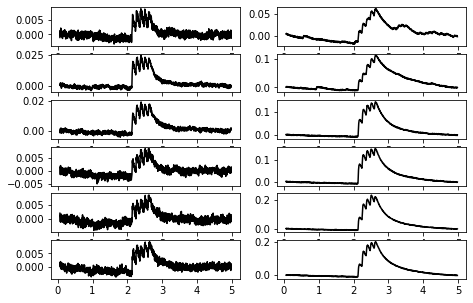

In [3]:
# 20201124 data
pkldir_20201124 = r'Z:\ilya\code\igaba2-code\GABA-titration-analysis\data\5AP'
pkls_1 = ['1_1', '1_2', '1_3', '1_4', '1_5', '1_6']
pkls_4409 =  ['4409_2', '4409_3', '4409_4', '4409_5', '4409_6', '4409_7']
n_recs_max = max([len(pkls_1), len(pkls_4409)])
pkl_list = [pkls_1, pkls_4409]
f, axs = plt.subplots(n_recs_max, 2, figsize = [7.43, 5])

j = 0
for pk in pkl_list:
    
    i=0
    for pkl in pk: # pkls_1 or pkls_4409

        full = pd.read_pickle(os.path.join(pkldir_20201124, pkl + ' full.pkl'))['Y'].to_numpy()
        bg = pd.read_pickle(os.path.join(pkldir_20201124, pkl + ' bg.pkl'))['Y'].to_numpy()
        t_vec = np.arange(beginning_frames_to_ignore,full.shape[0])/srate

        # remove first few frames (might be fast bleaching)
        full = full[beginning_frames_to_ignore:]
        bg = bg[beginning_frames_to_ignore:]

        full_dff = calc_dff_trace(bg, full)
        debleach_full_dff = debleach(full_dff, t_vec)
        axs[i,j].plot(t_vec, debleach_full_dff, 'k-')
        i+=1
    j+=1
    

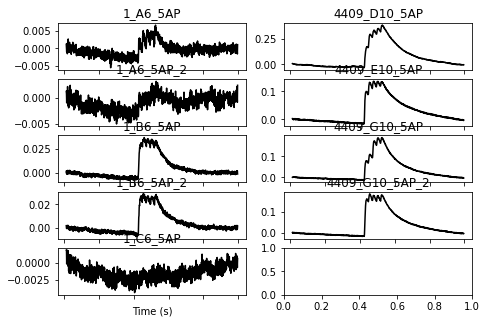

In [4]:
# 20201117 data
results = pd.read_csv(r'Z:\ilya\code\igaba2-code\GABA-titration-analysis\data\5AP\iGABASnFR-vs-4409-highRes-imaging-results-20201117.csv')
t_vec = np.arange(beginning_frames_to_ignore,results.shape[0])/srate

# pkldir_20201117 = r'D:\imaging_local\20201117_iGABASnFR_imaging_IK\synapse_imaging\4409_G10_5AP_synapses'

columns_1 = np.array(['1_A6_5AP', '1_A6_5AP_2', '1_B6_5AP', '1_B6_5AP_2', '1_C6_5AP'])
columns_4409 =  np.array(['4409_D10_5AP', '4409_E10_5AP', '4409_G10_5AP', '4409_G10_5AP_2'])
n_recs_max = max([len(columns_1), len(columns_4409)])

f, axs = plt.subplots(n_recs_max, 2, figsize = [7.43, 5])

all_columns = [columns_1, columns_4409]

j=0
for col in all_columns:
    
    i=0
    for c in col: # columns_1 or columns_4409
        column_name = c# '1_C6_5AP'# '4409_D10_5AP'
        bg = results[column_name + ' bg'][beginning_frames_to_ignore:].to_numpy()
        full = results[column_name + ' full'][beginning_frames_to_ignore:].to_numpy()

        full_dff = calc_dff_trace(bg, full)
        debleach_full_dff = debleach(full_dff, t_vec)

        axs[i,j].plot(t_vec, debleach_full_dff, 'k-')
        axs[i,j].set_xlabel('Time (s)')
        axs[i,j].set_title(column_name)
        axs[i,j].set_xticklabels([])
        
        # save samples
        if column_name == '4409_D10_5AP':
            dff_4409_D10_5AP = debleach_full_dff
        if column_name == '1_B6_5AP_2':
            dff_1_B6_5AP_2 = debleach_full_dff
        i+=1
    j+=1

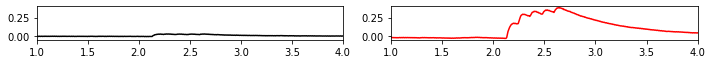

In [5]:
'''
plot superimposed representative iGABA and iGABA2 traces 
 - run previous cell first
'''

colorpalette = {'iGABASnFR': 'k', '514.4409': 'red'}

f,ax = plt.subplots(1,2,figsize=[10,1])
ax[0].plot(t_vec, dff_1_B6_5AP_2, color=colorpalette['iGABASnFR'])
ax[0].set_ylim([-0.05, 0.4])
ax[0].set_xlim([1,4])
ax[1].plot(t_vec, dff_4409_D10_5AP, color=colorpalette['514.4409'])
ax[1].set_ylim([-0.05, 0.4])
ax[1].set_xlim([1,4])
plt.tight_layout()
f.savefig('figs/high-mag-imaging-traces.pdf')

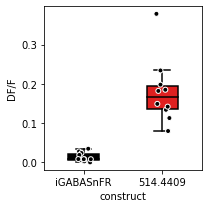

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# combined stats from plots above

dff_514_1 = pd.DataFrame(np.array([0.0061, 0.00289, 0.035, 0.028, 0.0003, .0084, .024, .0191, .0083, .0084, .0087, ]), columns=['iGABASnFR'])
dff_514_4409 = pd.DataFrame(np.array([0.182, 0.185, 0.134, 0.378, .08, .113, 0.142, .149, .234, .198]), columns=['514.4409'])

colorpalette = {'iGABASnFR': 'k', '514.4409': 'red'}
dff_combo = pd.concat([pd.melt(dff_514_1), pd.melt(dff_514_4409)])
dff_combo = dff_combo.rename(columns={'variable': 'construct', 'value':'DF/F'})

f = plt.figure(figsize=[3,3])
sns.boxplot(x='construct', y='DF/F', 
            data=dff_combo, 
            hue='construct', 
            showfliers=False, 
            palette=colorpalette, 
            dodge=False,width=0.4)
ax=sns.stripplot(data=dff_combo, 
              x='construct', y='DF/F', 
              color='black', 
              edgecolor = 'white', 
              linewidth = 1)

plt.tight_layout()
ax.get_legend().remove()
f.savefig('figs/high-mag-imaging-aggregate.pdf')